<a href="https://colab.research.google.com/github/drashyabansel/GenerativeAI/blob/main/Medical_Q%26A_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Q&A using GPT2

## Dataset Description

The dataset used in this project is the *Medical Question Answering Dataset* ([MedQuAD](https://github.com/abachaa/MedQuAD/tree/master)). It includes medical question-answer pairs along with additional information, such as the question type, the question *focus*, its UMLS(Unified Medical Language System) details like - Concept Unique Identifier(*CUI*) and Semantic *Type* and *Group*.

To know more about this data's collection, and construction method, refer to this [paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3119-4).

The data is extracted and is in CSV format with below features:

- **Focus**: the question focus
- **CUI**: concept unique identifier
- **SemanticType**
- **SemanticGroup**
- **Question**
- **Answer**

## Information

Healthcare professionals often have to refer to medical literature and documents while seeking answers to medical queries. Medical databases or search engines are powerful resources of upto date medical knowledge. However, the existing documentation is large and makes it difficult for professionals to retrieve answers quickly in a clinical setting. The problem with search engines and informative retrieval engines is that these systems return a list of documents rather than answers. Instead, healthcare professionals can use question answering systems to retrieve short sentences or paragraphs in response to medical queries. Such systems have the biggest advantage of generating answers and providing hints in a few seconds.

### Problem Statement

Fine-tune gpt2 model on medical-question-answering-dataset for performing response generation for medical queries.

### **GPT-2**

In recent years, the OpenAI GPT-2 exhibited an impressive ability to write coherent and passionate essays that exceeded what current language models can produce. The GPT-2 wasn't a particularly novel architecture - its architecture is very similar to the **decoder-only transformer**. The GPT2 was, however, a very large, transformer-based language model trained on a massive dataset.

Here, you are going to fine-tune the GPT2 model with the Medical data. Expected result should be that the model will be able to reply to the prompt related medical queries after fine-tuning.

To know more about GPT-2, refer [here](http://jalammar.github.io/illustrated-gpt2/).

### Installing Dependencies

In [1]:
%%capture
!pip -q uninstall pyarrow -y
!pip -q install pyarrow==15.0.2
!pip -q install datasets
!pip -q install accelerate
!pip -q install transformers

### <font color="#990000">Restart Session/Runtime</font>

### Import required packages

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

import warnings
warnings.filterwarnings('ignore')

In [3]:
#@title Download the dataset
!wget -q https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/MedQuAD.csv
!ls | grep ".csv"

MedQuAD.csv


**Read the MedQuAD.csv dataset**

**Hint:** `pd.read_csv()`

In [4]:
# Reading MedQuAD questions
pd.set_option("display.max_columns", None)
med_data = pd.read_csv("/content/MedQuAD.csv")
med_data.head()

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
0,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What is (are) Adult Acute Lymphoblastic Leukem...,Key Points - Adult acute lymphoblastic leukemi...
1,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What are the symptoms of Adult Acute Lymphobla...,"Signs and symptoms of adult ALL include fever,..."
2,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...
3,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis (chance of re...
4,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...


In [5]:
# Get Data Information
med_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Focus          16398 non-null  object
 1   CUI            15847 non-null  object
 2   SemanticType   15815 non-null  object
 3   SemanticGroup  15847 non-null  object
 4   Question       16412 non-null  object
 5   Answer         16407 non-null  object
dtypes: object(6)
memory usage: 769.4+ KB


### Pre-processing and EDA

**Perform below operations on the dataset **

- Handle missing values
- Remove duplicates from data considering `Question` and `Answer` columns

- **Handle missing values**

In [6]:
# We have some unanswered questions in our dataset.
display(med_data[med_data["Answer"].isna()])

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
2263,"Emery-Dreifuss muscular dystrophy, dominant type",C0410189,T047,Disorders,What is (are) Emery-Dreifuss muscular dystroph...,NaN
2264,"Emery-Dreifuss muscular dystrophy, X-linked",C0410189,T047,Disorders,What is (are) Emery-Dreifuss muscular dystroph...,NaN
2400,Familial HDL deficiency,C2931838,T047,Disorders,What is (are) Familial HDL deficiency ?,NaN
2876,HELLP syndrome,C0162739,T047,Disorders,What is (are) HELLP syndrome ?,NaN
6021,X-linked lymphoproliferative syndrome,C0549463,T191,Disorders,What is (are) X-linked lymphoproliferative syn...,NaN


In [7]:
med_data[med_data["CUI"]=="C0410189"]

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
2263,"Emery-Dreifuss muscular dystrophy, dominant type",C0410189,T047,Disorders,What is (are) Emery-Dreifuss muscular dystroph...,NaN
2264,"Emery-Dreifuss muscular dystrophy, X-linked",C0410189,T047,Disorders,What is (are) Emery-Dreifuss muscular dystroph...,NaN
2265,"Emery-Dreifuss muscular dystrophy, X-linked",C0410189,T047,Disorders,What are the symptoms of Emery-Dreifuss muscul...,What are the signs and symptoms of Emery-Dreif...
7658,Emery-Dreifuss muscular dystrophy,C0410189,T047,Disorders,What is (are) Emery-Dreifuss muscular dystrophy ?,Emery-Dreifuss muscular dystrophy is a conditi...
7659,Emery-Dreifuss muscular dystrophy,C0410189,T047,Disorders,How many people are affected by Emery-Dreifuss...,X-linked Emery-Dreifuss muscular dystrophy is ...
7660,Emery-Dreifuss muscular dystrophy,C0410189,T047,Disorders,What are the genetic changes related to Emery-...,Mutations in the EMD and LMNA genes cause Emer...
7661,Emery-Dreifuss muscular dystrophy,C0410189,T047,Disorders,Is Emery-Dreifuss muscular dystrophy inherited ?,Emery-Dreifuss muscular dystrophy can have sev...
7662,Emery-Dreifuss muscular dystrophy,C0410189,T047,Disorders,What are the treatments for Emery-Dreifuss mus...,These resources address the diagnosis or manag...


In [8]:
med_data[med_data["CUI"]=="C2931838"]

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
2400,Familial HDL deficiency,C2931838,T047,Disorders,What is (are) Familial HDL deficiency ?,NaN
2401,Familial HDL deficiency,C2931838,T047,Disorders,What are the symptoms of Familial HDL deficien...,What are the signs and symptoms of Familial HD...
7828,familial HDL deficiency,C2931838,T047,Disorders,What is (are) familial HDL deficiency ?,Familial HDL deficiency is a condition charact...
7829,familial HDL deficiency,C2931838,T047,Disorders,How many people are affected by familial HDL d...,"Familial HDL deficiency is a rare disorder, al..."
7830,familial HDL deficiency,C2931838,T047,Disorders,What are the genetic changes related to famili...,Mutations in the ABCA1 gene or the APOA1 gene ...
7831,familial HDL deficiency,C2931838,T047,Disorders,Is familial HDL deficiency inherited ?,Familial HDL deficiency is inherited in an aut...
7832,familial HDL deficiency,C2931838,T047,Disorders,What are the treatments for familial HDL defic...,These resources address the diagnosis or manag...


In [9]:
med_data[med_data["CUI"]=="C0162739"]

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
2876,HELLP syndrome,C0162739,T047,Disorders,What is (are) HELLP syndrome ?,NaN
2877,HELLP syndrome,C0162739,T047,Disorders,What are the symptoms of HELLP syndrome ?,What are the signs and symptoms of HELLP syndr...
2878,HELLP syndrome,C0162739,T047,Disorders,What causes HELLP syndrome ?,What causes HELLP syndrome? Doctors are still ...


In [10]:
med_data[med_data["CUI"]=="C0549463"]

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
6021,X-linked lymphoproliferative syndrome,C0549463,T191,Disorders,What is (are) X-linked lymphoproliferative syn...,NaN
6022,X-linked lymphoproliferative syndrome,C0549463,T191,Disorders,What are the symptoms of X-linked lymphoprolif...,What are the signs and symptoms of X-linked ly...
11343,X-linked lymphoproliferative disease,C0549463,T191,Disorders,What is (are) X-linked lymphoproliferative dis...,X-linked lymphoproliferative disease (XLP) is ...
11344,X-linked lymphoproliferative disease,C0549463,T191,Disorders,How many people are affected by X-linked lymph...,XLP1 is estimated to occur in about 1 per mill...
11345,X-linked lymphoproliferative disease,C0549463,T191,Disorders,What are the genetic changes related to X-link...,Mutations in the SH2D1A and XIAP genes cause X...
11346,X-linked lymphoproliferative disease,C0549463,T191,Disorders,Is X-linked lymphoproliferative disease inheri...,This condition is generally inherited in an X-...
11347,X-linked lymphoproliferative disease,C0549463,T191,Disorders,What are the treatments for X-linked lymphopro...,These resources address the diagnosis or manag...


In [11]:
# Since we need to be very carefull while answering the medical query, it will be good if drop missing information than
# filling it with the similarity. Although this won't make big impact. And Fill Others with UNK
med_data = med_data.dropna(subset=["Answer"]).fillna("UNK")
med_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 16407 entries, 0 to 16411
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Focus          16407 non-null  object
 1   CUI            16407 non-null  object
 2   SemanticType   16407 non-null  object
 3   SemanticGroup  16407 non-null  object
 4   Question       16407 non-null  object
 5   Answer         16407 non-null  object
dtypes: object(6)
memory usage: 897.3+ KB


- **Remove duplicates from data considering `Question` and `Answer` columns**

In [12]:
# Question and Answer are first required to lower case and we can drop duplicate records.
med_data["Question"] = med_data["Question"].str.lower()
med_data["Answer"] = med_data["Answer"].str.lower()
med_data.drop_duplicates(subset=["Question", "Answer"], inplace=True)
med_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 16359 entries, 0 to 16411
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Focus          16359 non-null  object
 1   CUI            16359 non-null  object
 2   SemanticType   16359 non-null  object
 3   SemanticGroup  16359 non-null  object
 4   Question       16359 non-null  object
 5   Answer         16359 non-null  object
dtypes: object(6)
memory usage: 894.6+ KB


**Display the category name, and the number of records belonging to top 100 categories of `Focus` column **

In [13]:
# Total categories in Focus column
print("Total no of categories : ",med_data["Focus"].nunique())

Total no of categories :  5126


In [14]:
# Displaying the distinct categories of Focus column and the number of records belonging to each category
# (Top 100 only)
print("The number of records belonging to top 100 categories of Focus column : ")
top_100_focus = med_data[["Focus"]].value_counts()[:100]
top_100_focus.head(10)

The number of records belonging to top 100 categories of Focus column : 


,count
Focus,
Breast Cancer,53
Prostate Cancer,43
Stroke,35
Skin Cancer,34
Alzheimer's Disease,30
Lung Cancer,29
Colorectal Cancer,29
Heart Attack,28
Heart Failure,28


In [15]:
top_100_focus.tail(10)

,count
Focus,
Medullary Sponge Kidney,11
Urinary Retention,11
Vesicoureteral Reflux,11
Laron syndrome,11
IgA Nephropathy,11
Camurati-Engelmann disease,11
Danon disease,11
Klinefelter syndrome,11
Porphyria,11


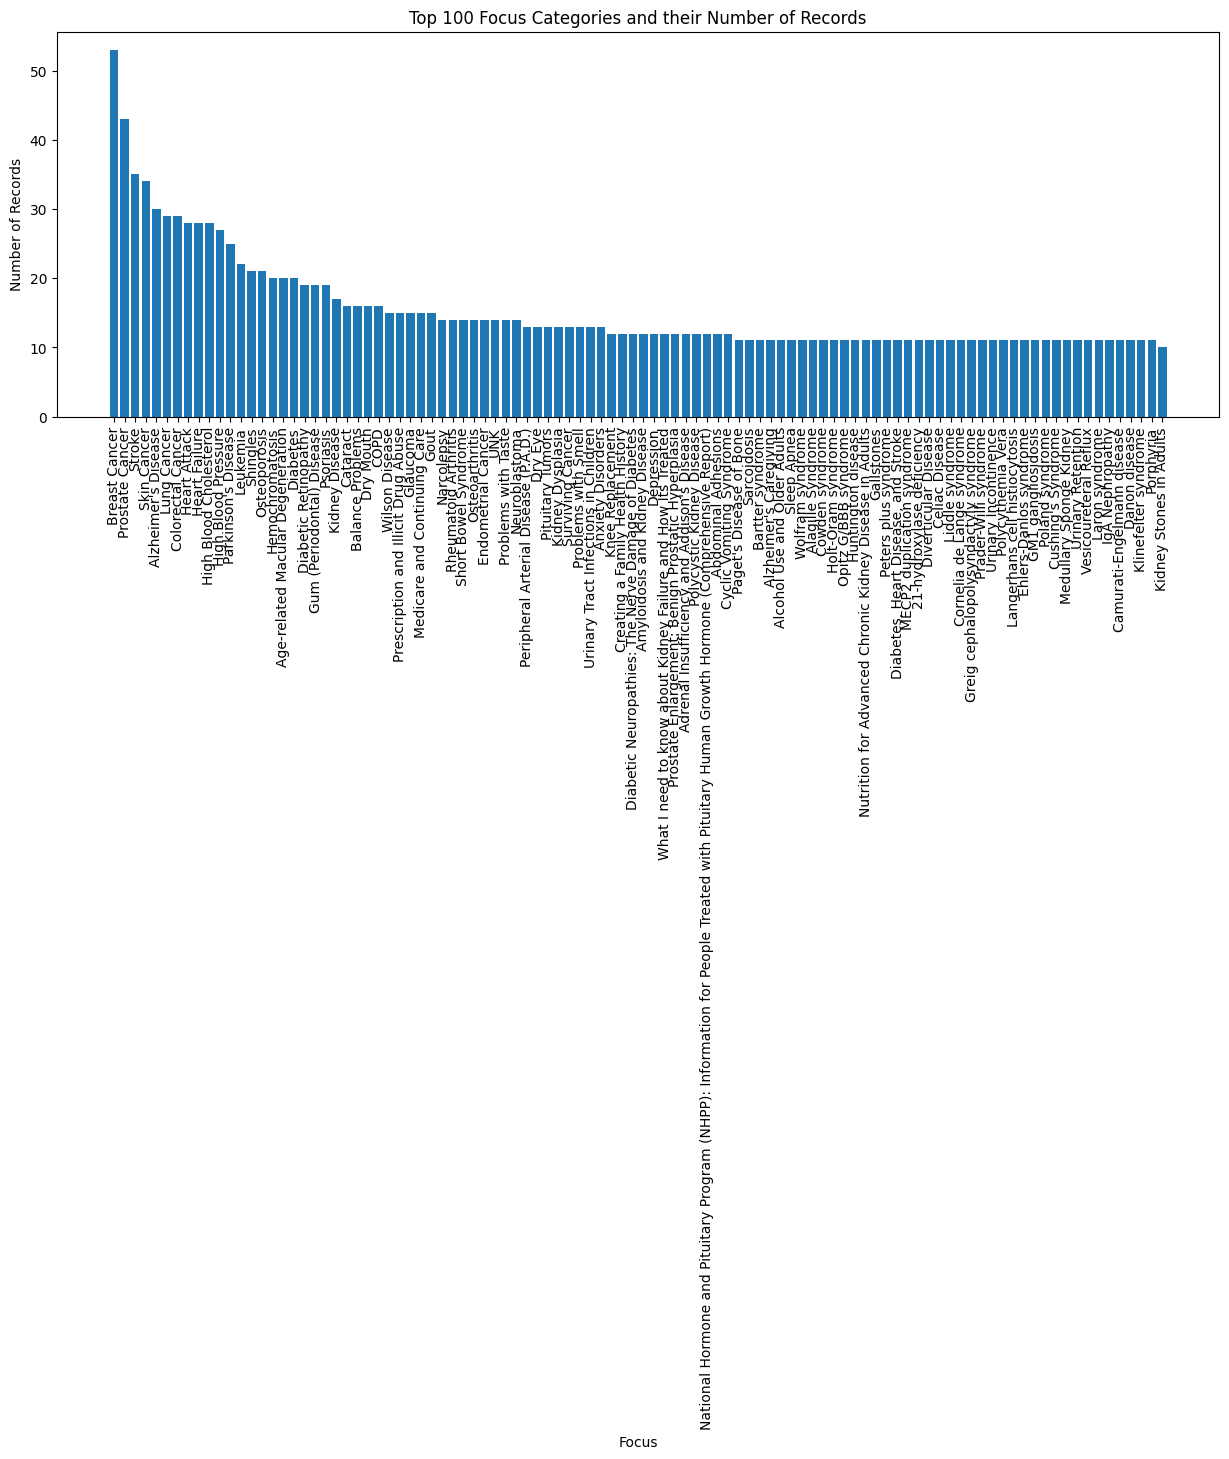

In [16]:
# prompt: plot top_100_focus

plt.figure(figsize=(15, 5))
plt.bar(top_100_focus.index.get_level_values(0), top_100_focus.values)
plt.xticks(rotation=90)
plt.xlabel("Focus")
plt.ylabel("Number of Records")
plt.title("Top 100 Focus Categories and their Number of Records")
plt.show()


In [17]:
# Top 100 Focus categories names
top_100_focus.index.get_level_values(0)

Index(['Breast Cancer', 'Prostate Cancer', 'Stroke', 'Skin Cancer',
       'Alzheimer's Disease', 'Lung Cancer', 'Colorectal Cancer',
       'Heart Attack', 'Heart Failure', 'High Blood Cholesterol',
       'High Blood Pressure', 'Parkinson's Disease', 'Leukemia', 'Shingles',
       'Osteoporosis', 'Hemochromatosis', 'Age-related Macular Degeneration',
       'Diabetes', 'Diabetic Retinopathy', 'Gum (Periodontal) Disease',
       'Psoriasis', 'Kidney Disease', 'Cataract', 'Balance Problems',
       'Dry Mouth', 'COPD', 'Wilson Disease',
       'Prescription and Illicit Drug Abuse', 'Glaucoma',
       'Medicare and Continuing Care', 'Gout', 'Narcolepsy',
       'Rheumatoid Arthritis', 'Short Bowel Syndrome', 'Osteoarthritis',
       'Endometrial Cancer', 'UNK', 'Problems with Taste', 'Neuroblastoma',
       'Peripheral Arterial Disease (P.A.D.)', 'Dry Eye', 'Pituitary Tumors',
       'Kidney Dysplasia', 'Surviving Cancer', 'Problems with Smell',
       'Urinary Tract Infections in Child

### Create Training and Validation set

**Create training and validation set**

- Consider 4 samples per `Focus` category, for each top 100 categories, from the dataset (It will give 400 samples for training)

- Consider 1 sample per `Focus` category (different from training set), for each top 100 categories, from the dataset (It will give 100 samples for validation)

In [18]:
DATA_FOR_TRAINING = pd.DataFrame()
for category in top_100_focus.index.get_level_values(0):
    DATA_FOR_TRAINING = pd.concat([DATA_FOR_TRAINING, med_data[med_data["Focus"]==category].sample(5, random_state=42)])

TRAIN_SET, VALIDATION_SET = train_test_split(DATA_FOR_TRAINING, test_size=0.2, random_state=42)

print(TRAIN_SET.shape)
print(VALIDATION_SET.shape)

(400, 6)
(100, 6)


### Pre-process `Question` and `Answer` text

**Perform below tasks:**

- Combine `Question` and `Answer` for train and validation data as shown below:
    - sequence = *'\<question\>' + question-text + '\<answer\>' + answer-text + '\<end\>'*

- Join the combined text using '\n' into a single string for training and validation separately

- Save the training and validation strings as separate text files

- **Combine Question and Answer for train and val data**

In [19]:
# Combine Questions and Answers for train and val data
## sequence = '<question> ' + question + ' <answer> ' + answer + ' <end>'

def combine_question_answer(row):
    return "<question>" + row["Question"].strip() + "<answer>" + row["Answer"].strip() + " <end>"

TRAIN_SET["sequence"] = TRAIN_SET.apply(combine_question_answer, axis=1)
VALIDATION_SET["sequence"] = VALIDATION_SET.apply(combine_question_answer, axis=1)

In [20]:
TRAIN_SET.head()

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer,sequence
12684,Diabetic Neuropathies: The Nerve Damage of Dia...,C0161479,T037,Disorders,what is (are) diabetic neuropathies: the nerve...,autonomic neuropathy affects the nerves that c...,<question>what is (are) diabetic neuropathies:...
7647,Ehlers-Danlos syndrome,C0013720,T019,Disorders,what are the treatments for ehlers-danlos synd...,these resources address the diagnosis or manag...,<question>what are the treatments for ehlers-d...
597,Skin Cancer,C0007114,T191,Disorders,how to prevent skin cancer ?,key points - avoiding risk factors and increas...,<question>how to prevent skin cancer ?<answer>...
16070,Sleep Apnea,C0037315,T047,Disorders,how to diagnose sleep apnea ?,doctors diagnose sleep apnea based on medical ...,<question>how to diagnose sleep apnea ?<answer...
13431,Alagille Syndrome,C0085280,T019,Disorders,what to do for alagille syndrome ?,"researchers have not found that eating, diet, ...",<question>what to do for alagille syndrome ?<a...


In [21]:
TRAIN_SET["sequence"].loc[12689]

'<question>what are the treatments for diabetic neuropathies: the nerve damage of diabetes ?<answer>the first treatment step is to bring blood glucose levels within the normal range to help prevent further nerve damage. blood glucose monitoring, meal planning, physical activity, and diabetes medicines or insulin will help control blood glucose levels. symptoms may get worse when blood glucose is first brought under control, but over time, maintaining lower blood glucose levels helps lessen symptoms. good blood glucose control may also help prevent or delay the onset of further problems. as scientists learn more about the underlying causes of neuropathy, new treatments may become available to help slow, prevent, or even reverse nerve damage. as described in the following sections, additional treatment depends on the type of nerve problem and symptom. pain relief doctors usually treat painful diabetic neuropathy with oral medications, although other types of treatments may help some peop

In [22]:
VALIDATION_SET.head()

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer,sequence
11940,Gallstones,C0008350,T047,Disorders,what is (are) gallstones ?,your gallbladder is a pear-shaped organ under ...,<question>what is (are) gallstones ?<answer>yo...
15324,Osteoporosis,C0029456,T047,Disorders,what is (are) osteoporosis ?,a bone disease osteoporosis is a disease that ...,<question>what is (are) osteoporosis ?<answer>...
12658,"Diabetes, Heart Disease, and Stroke",C0038454,T047,Disorders,"what is (are) diabetes, heart disease, and str...","if you have diabetes, you are at least twice a...","<question>what is (are) diabetes, heart diseas..."
15938,Narcolepsy,C0027404,T047,Disorders,what causes narcolepsy ?,most people who have narcolepsy have low level...,<question>what causes narcolepsy ?<answer>most...
15463,Psoriasis,C0033860,T047,Disorders,what is (are) psoriasis ?,the most common form of psoriasis is called pl...,<question>what is (are) psoriasis ?<answer>the...


- **Join the combined text using '\n' into a single string for training and validation separately**

In [23]:
# Train and Validation text for all Q&As

train_text = "\n".join(TRAIN_SET["sequence"].tolist())
validation_text = "\n".join(VALIDATION_SET["sequence"].tolist())

- **Save the training and validation strings as text files**

In [24]:
# Save the training and validation data as text files

with open("train.txt", "w") as f:
    f.write(train_text)

with open("validation.txt", "w") as f:
    f.write(validation_text)

**Load pre-trained GPT2Tokenizer**

In [25]:
# Set up the tokenizer
checkpoint = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

**Tokenize train and validation data**

- Use the loaded pre-trained tokenizer
- Use training and validation data saved in text files

**Hint:**

`from datasets import load_dataset`

`dataset = load_dataset("text", data_files={...})`

In [26]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("text", data_files={"train": "train.txt", "validation": "validation.txt"})

# Tokenize Data
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=1024)

tokenized_dataset = dataset.map(
    tokenize_function, batched=True,
    batch_size=8, remove_columns=["text"]
    )
tokenized_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 100
    })
})

**Create a DataCollator object**

**Hint:** `DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False, return_tensors="pt")`

Data collators are objects that:

- will form a batch by using a list of dataset elements as input
- may apply some processing (like padding)

One of the data collators, `DataCollatorForLanguageModeling`, can also apply some random data augmentation (like random masking) on the formed batch.

<br>

`DataCollatorForLanguageModeling` is a data collator used for language modeling. Inputs are dynamically padded to the maximum length of a batch if they are not all of the same length.

Parameters:

- ***tokenizer:*** The tokenizer used for encoding the data.
- ***mlm*** (bool, optional, default=True): Whether or not to use masked language modeling.
    - If set to False, the labels are the same as the inputs with the padding tokens ignored (by setting them to -100).
    - Otherwise, the labels are -100 for non-masked tokens and the value to predict for the masked token.
- ***return_tensors*** (str): The type of Tensor to return. Allowable values are “np”, “pt” and “tf” for numpy array, pytorch tensor, and tensorflow tensor respectively.

To know more about `DataCollatorForLanguageModeling` parameters, refer [here](https://huggingface.co/docs/transformers/v4.32.0/en/main_classes/data_collator#transformers.DataCollatorForLanguageModeling).

In [27]:
# Create a Data collator object
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False, return_tensors="pt")

**Load pre-trained GPT2LMHeadModel**

In [28]:
# Set up the model
model = GPT2LMHeadModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

**Fine-tune GPT2 Model **

- Specify training arguments and create a TrainingArguments object (Use 30 epochs)

- Train a GPT-2 model using the provided training arguments

- Save the resulting trained model and tokenizer to a specified output directory

In [29]:
# Set up the training arguments

model_output_path = "/content/gpt_model"

training_args = TrainingArguments(
    output_dir=model_output_path,
    num_train_epochs=30,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    remove_unused_columns=False
    )

In [30]:
# Train the model

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"]
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: drashyabansel (drashyabansel06) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
500,2.212500
1000,1.638000
1500,1.288000
2000,1.035400
2500,0.807600
3000,0.654200
3500,0.543300
4000,0.458100
4500,0.400300
5000,0.359000


TrainOutput(global_step=6000, training_loss=0.8370171229044596, metrics={'train_runtime': 4005.388, 'train_samples_per_second': 2.996, 'train_steps_per_second': 1.498, 'total_flos': 2506679592192000.0, 'train_loss': 0.8370171229044596, 'epoch': 30.0})

In [31]:
# Save the model
trainer.save_model(model_output_path)

# Save the tokenizer
tokenizer.save_pretrained(model_output_path)

('/content/gpt_model/tokenizer_config.json',
 '/content/gpt_model/special_tokens_map.json',
 '/content/gpt_model/vocab.json',
 '/content/gpt_model/merges.txt',
 '/content/gpt_model/added_tokens.json')

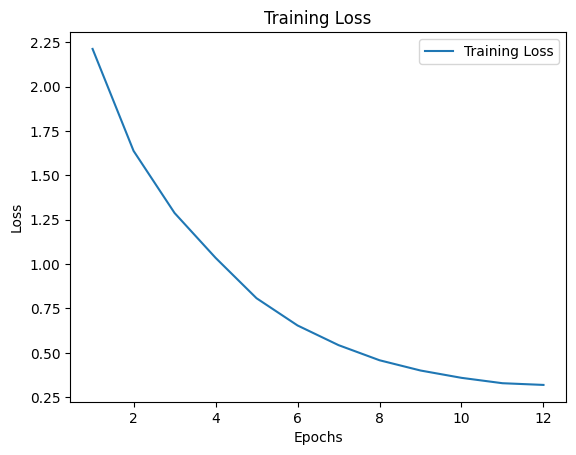

In [32]:
# prompt: plot the training and validation loss

import matplotlib.pyplot as plt

# Assuming you have the training and validation loss stored in a list or dictionary
# Replace 'trainer.state.log_history' with your actual loss data
training_loss = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry and 'eval_loss' not in entry]

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss')
# plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


**Test Model with user input prompts **

- Create `generate_response()` function that takes a trained *model*, *tokenizer*, and a *prompt* string as input and generates a response using the GPT-2 model

- Test it with some user input prompts

In [33]:
def generate_response(model, tokenizer, prompt, max_length=200):
  """
  Generates a response using the GPT-2 model.

  Args:
    model: The trained GPT-2 model.
    tokenizer: The tokenizer used for the model.
    prompt: The input prompt string.

  Returns:
    The generated response string.
  """
  input_ids = tokenizer.encode(prompt, return_tensors='pt')
  attention_mask = torch.ones(input_ids.shape, dtype=torch.long)
  output = model.generate(input_ids, attention_mask=attention_mask, max_length=max_length)
  response = tokenizer.decode(output[0], skip_special_tokens=True)
  return response


In [34]:
# Load the fine-tuned model and tokenizer

fine_tune_model = GPT2LMHeadModel.from_pretrained(model_output_path)
fine_tune_tokenizer = GPT2Tokenizer.from_pretrained(model_output_path)

In [35]:
# Testing with a sample prompt 1

prompt = "What precautions to take for a healthy life?"
response = generate_response(fine_tune_model, fine_tune_tokenizer, prompt)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'What precautions to take for a healthy life? - talk with your doctor if you think you may be at risk for cancer. - talk with your doctor if you think you may be at risk for cancer. - talk with your doctor if you think you may be at risk for heart disease, stroke, certain medicines, or other medical problems. - talk with your doctor about any steps you may take to lower your risk of getting cancer. - take steps to lower your risk of getting type 2 diabetes and heart disease. talk with your doctor if you think you may be at risk for heart disease, stroke, certain medicines, or other medical problems. - talk with your doctor about any steps you may take to lower your risk of getting type 2 diabetes and heart disease. - talk with your doctor about any steps you may take to lower your risk of getting certain cancers. - take steps to lower your risk of getting certain types of lung cancer, including invasive lung cancer. talk with your doctor about any steps'

In [36]:
# Testing with a sample prompt 2

prompt = "What precaution to take during cancer"
response = generate_response(fine_tune_model, fine_tune_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"What precaution to take during cancer treatment: don't let your doctor tell you to stop taking certain medicines. don't let your doctor tell you to stop taking certain medicines. don't let your doctor tell you to stop taking certain medicines. talk with your doctor about the best way to manage your cancer. for example, you may want to know whether taking certain medicines will help you feel better, prevent some symptoms, or help you cope with the loss of unwanted side effects. talk with your doctor about the best way to manage your cancer. for example, you may want to know whether taking certain medicines will help you feel better, prevent some symptoms, or help you cope with the loss of unwanted side effects. take your medicines slowly. if you take certain medicines slowly, you may feel better and take fewer side effects. talk with your doctor about the best way to manage your cancer. for example, you may want to know whether taking certain medicines will help you feel better, preven

**Compare the performance of a *GPT2 model* with the *GPT2 model fine-tuned* on MedQuAD data**

- Load another pre-trained GPT2LMHeadModel and do not fine-tune it

- To generate response using the untuned model, pass it as a parameter to `generate_response()` function

- Test both models (fine-tuned and untuned) with below user input prompts:

    - "What precautions to take for a healthy life?"
    - "What to do after being diagnosed with cancer?"
    - "What to do when feeling sick?"

In [37]:
# Load a pre-trained GPT2 model, do not finetune it with MedQuAD data

untuned_model = GPT2LMHeadModel.from_pretrained("gpt2")
untuned_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [38]:
# Testing with finetuned model: prompt 1

prompt = "What precautions to take for a healthy life?"
response = generate_response(fine_tune_model, fine_tune_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'What precautions to take for a healthy life? - talk with your doctor if you think you may be at risk for cancer. - talk with your doctor if you think you may be at risk for cancer. - talk with your doctor if you think you may be at risk for heart disease, stroke, certain medicines, or other medical problems. - talk with your doctor about any steps you may take to lower your risk of getting cancer. - take steps to lower your risk of getting type 2 diabetes and heart disease. talk with your doctor if you think you may be at risk for heart disease, stroke, certain medicines, or other medical problems. - talk with your doctor about any steps you may take to lower your risk of getting type 2 diabetes and heart disease. - talk with your doctor about any steps you may take to lower your risk of getting certain cancers. - take steps to lower your risk of getting certain types of lung cancer, including invasive lung cancer. talk with your doctor about any steps'

In [39]:
# Testing with untuned model: prompt 1

prompt = "What precautions to take for a healthy life?"
response = generate_response(untuned_model, untuned_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"What precautions to take for a healthy life?\n\nThe following are some of the most common questions you'll hear from your doctor or nurse about your health.\n\nWhat are the risks of taking a drug that can cause cancer?\n\nThe risks of taking a drug that can cause cancer are very high.\n\nWhat are the risks of taking a drug that can cause cancer?\n\nThe risks of taking a drug that can cause cancer are very high.\n\nWhat are the risks of taking a drug that can cause cancer?\n\nThe risks of taking a drug that can cause cancer are very high.\n\nWhat are the risks of taking a drug that can cause cancer?\n\nThe risks of taking a drug that can cause cancer are very high.\n\nWhat are the risks of taking a drug that can cause cancer?\n\nThe risks of taking a drug that can cause cancer are very high.\n\nWhat are the risks of taking a drug that can cause"

In [40]:
# Testing with finetuned model: prompt 2

prompt = "What to do after being diagnosed with cancer?"
response = generate_response(fine_tune_model, fine_tune_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'What to do after being diagnosed with cancer? - talk with your doctor if you think you may have a risk factor for cancer. - talk with your doctor if you think you may have a risk factor for cancer. - talk with your doctor if you think you may have a family member or friend who has had cancer. - talk with people who have had cancer with you. - ask them about their personal stories about the cancer. - if you have a risk factor for cancer, talk with your doctor about that risk. (above) taking steps to lower your risk of cancer: - talk with your doctor when you first notice signs of cancer to lower your chance of getting a disease. - ask your doctor about any family members or friends who have had cancer. - if you have a risk factor for cancer, talk with your doctor about that risk. (above) taking steps to lower your risk of cancer: - ask your doctor when you first notice signs of cancer to lower your chance of getting a'

In [41]:
# Testing with untuned model: prompt 2

prompt = "What to do after being diagnosed with cancer?"
response = generate_response(untuned_model, untuned_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"What to do after being diagnosed with cancer?\n\nThe first step is to get your doctor's approval for a treatment.\n\nIf you have a cancer diagnosis, you may need to get a second opinion.\n\nIf you have a cancer diagnosis, you may need to get a second opinion. If you have a cancer diagnosis, you may need to get a third opinion.\n\nIf you have a cancer diagnosis, you may need to get a third opinion. If you have a cancer diagnosis, you may need to get a fourth opinion.\n\nIf you have a cancer diagnosis, you may need to get a fourth opinion. If you have a cancer diagnosis, you may need to get a fifth opinion.\n\nIf you have a cancer diagnosis, you may need to get a fifth opinion. If you have a cancer diagnosis, you may need to get a sixth opinion.\n\nIf you have a cancer diagnosis, you may need to get a sixth opinion. If you have"

In [42]:
# Testing with finetuned model: prompt 3

prompt = "What to do when feeling sick?"
response = generate_response(fine_tune_model, fine_tune_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'What to do when feeling sick? - ask your doctor about any changes in your appetite or sense of smell. - if you have a change in your appetite, talk with your doctor about it. - if you smoke, stop. ask your doctor about any changes in your sense of smell. if you have a change in your appetite, talk with your doctor about it. if you smoke, stop. ask your doctor about any changes in your sense of smell. - if you have a change in your sense of taste, brush your teeth twice a day (with a fluoride toothpaste). if you smoke, stop. ask your doctor about any changes in your sense of taste. brush your teeth twice a day (with a fluoride toothpaste). if you have a change in your sense of smell, brush your teeth twice a day (with a dental floss). if you smoke, stop. <end>treatments for abdominal pain <end>eating well, being active, and remaining independent are'

In [43]:
# Testing with untuned model: prompt 3

prompt = "What to do when feeling sick?"
response = generate_response(untuned_model, untuned_tokenizer, prompt, max_length=200)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"What to do when feeling sick?\n\nThe first thing you should do is to get your body to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick, you should take a few minutes to relax.\n\nIf you're feeling sick"